In [1]:
# csv to process csv input and sqlite to help query data easier after preprocessing
# Code compatible with python 3, except for print that is now a function and have to be called like print()
import csv
import sqlite3

#Import matplot and numpy libs for building up some charts
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#defined session in ms
session_time = 600000

#Local support variables
sessiondict = {'session_id': 0} 
counter = 0

In [3]:
# This can be tuned to work without using this sqlite and working with internal lists and dictionaries.
# Considering the provided data i decided that the simplest tool for the task was to write my analysis using any SQL db.
# Initiate sqlitedb in memory, without persisting
db = sqlite3.connect(':memory:')
dbc = db.cursor()

In [4]:
# Create Tables
dbc.execute('''CREATE TABLE usage (ms_played int, context text, track_id text, product text, end_timestamp number,   
                user_id text)''')
dbc.execute('''CREATE TABLE users (gender text, age_range text, country text, acct_age_weeks int, user_id text)''')
dbc.execute('''CREATE TABLE sessions (user_id text, session_id int,session_start int, session_end int, 
                PRIMARY KEY (user_id, session_id))''')
db.commit()

In [5]:
# Support Functions, may be useful in the future for data processing.
def getUserInfo(userlist,uid):
    return filter(lambda user: user['user_id'] == uid, userlist)[0]

def getUserIdInList(userlist,uid):
    for i, row in enumerate(userlist):
        if row['user_id'] == uid:
            return i


In [6]:
# Open user csv file and process to Import into sqlite DB.
with open('user_data_sample.csv', 'r') as fusers:
    rusers = csv.reader(fusers)
    next(rusers)
    for row in rusers:
        #Load users data
        dbc.execute('''INSERT INTO users VALUES (?,?,?,?,?)''', row)
    db.commit()


In [7]:
#Open Usage cds File and process to import into sqlite DB and Process User session Usage.
with open('end_song_sample.csv', 'r') as fusage:
    rusage = csv.DictReader(fusage)
    #Sort List for later session breaks
    sortedusage = list(sorted(rusage, key = lambda x: (x['user_id'], x['end_timestamp'])))
    for i, row in enumerate(sortedusage):
        #Load usage date
        dbc.execute('''INSERT INTO usage (ms_played,context,track_id,product,end_timestamp,user_id) 
                                VALUES (:ms_played,:context,:track_id,:product,:end_timestamp,:user_id)''', row)
        # if counter > 10:
            # break
        if i+1 >= len(sortedusage): break
        #Initialize Session
        if sessiondict['session_id'] == 0: 
            sessiondict = {
                'user_id' : row['user_id'],
                'session_id' : 1,
                'session_start': row['end_timestamp'],
                'session_end': row['end_timestamp']
            }

        #Calculate session using timestamp if its a contiguous user.
        if (sortedusage[i+1]['user_id'] == row['user_id']):
            #will compare next timestamo with current and check session time with configured defined session 
            if (float(sortedusage[i+1]['end_timestamp']) - float(row['end_timestamp'])) >= session_time:   
                #save current session in DB (this could be optimized running maybe with only internal lists before sending)
                dbc.execute('''INSERT OR REPLACE INTO sessions (user_id,session_id,session_start,session_end) 
                                VALUES (:user_id,:session_id,:session_start,:session_end)''', sessiondict)
                #Update session time and session counter per new session in user.
                sessiondict['session_start'] = sortedusage[i+1]['end_timestamp']
                sessiondict['session_id'] += 1
            else:
                #Update session end time if session is continued
                sessiondict['session_end'] = row['end_timestamp']
        else:
            sessiondict['session_id'] = 0
            counter += 1
    db.commit()

In [8]:
#Run Queries
# Warm-up (please do this first):
# Determine whether male and female listeners are significantly different in their overall listening 
# (in terms of the count of track listens, or in terms of the total time spent listening)
dbc.execute('''SELECT users.gender, count(usage.track_id), count(DISTINCT usage.track_id), sum(ms_played)
                FROM usage
                INNER JOIN users ON (users.user_id = usage.user_id)
                GROUP BY users.gender
                ''')
#Python 3 print is a function
pieGender = {
    'activities' : [],
    'totaltime' : [],
    'labels' : []
}

print (','.join(['Gender','Activities','Unique Tracks','Total Time Played']))
for row in dbc:
    print (','.join(str(bit) for bit in row))
    pieGender['labels'].append(str(row[0]))
    pieGender['activities'].append(str(row[1]))
    pieGender['totaltime'].append(str(row[3]))

Gender,Activities,Unique Tracks,Total Time Played
female,649178,161590,83320664240
male,691479,207131,89166774194
unknown,2234,1409,358687857


WarmUp data.


<IPython.core.display.Javascript object>


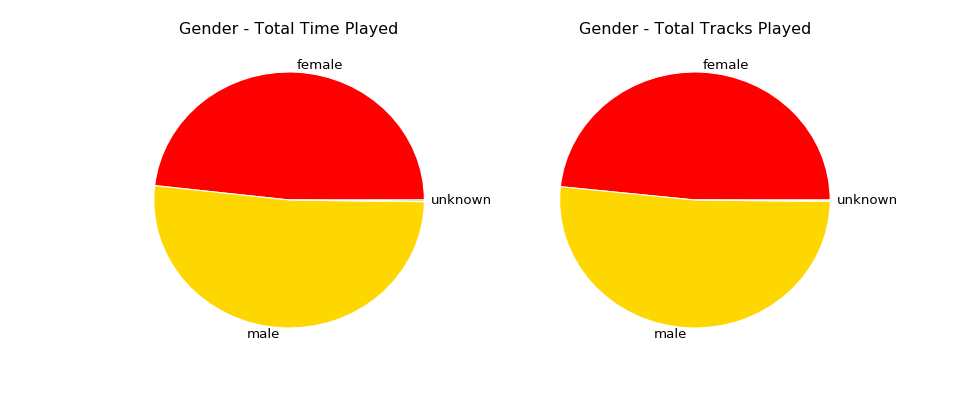

This analisys didnt give any conclusion, since the two measures in play were too simillar.


In [9]:
print ("WarmUp data.")
# Create PLot
fig = plt.figure(figsize=[12, 5])
cmap = plt.cm.prism
colors = cmap(np.linspace(0., 1., len(pieGender['labels'])))

# Add SubPlot for Chart 1
ax = fig.add_subplot(122)
ax.set_title("Gender - Total Tracks Played");
gender_pie_chart_act = ax.pie(pieGender['activities'], colors=colors, labels=pieGender['labels'], labeldistance=1.05)
for pie_wedge in gender_pie_chart_act[0]:
    pie_wedge.set_edgecolor('white')
    
# Add SubPlot for Chart 2
ax2 = fig.add_subplot(121)
ax2.set_title("Gender - Total Time Played");
gender_pie_chart_act = ax2.pie(pieGender['totaltime'], colors=colors, labels=pieGender['labels'], labeldistance=1.05)
for pie_wedge in gender_pie_chart_act[0]:
    pie_wedge.set_edgecolor('white')

print ("This analisys didnt give any conclusion, since the two measures in play were too simillar.")

In [10]:
# Analysis suggestion 1: 
# Break the user listening into sessions (exactly what is a listening session is up to you to define)
# Look for correlations between user demographic features (or their behavior) and their overall listening,
#  or their average session lengths
# Analysis suggestion 2:
# Find a clustering of user categories that delineates some interesting or useful behavior traits 
# (or show that no clustering makes sense)

# With the current knowledge, i just used time of continuous playing to find an user session.
# Session time was calculated based on configured session_time_threshold variable on beggining of application

# Initially set for 600000ms, which means that if the user stop playing music for 600000ms or more, it will start a new 
# Playing session for that when the user is back playing songs. 

In [11]:
# Find Overall Listen information for each active User Per Countries that contain data matching a profile
# Total Seconds of music playing  
# Average User Session time, based on configured session_time_threshold variable on beggining of application
# Number of Unique Tracks
# Number of Total Play Activities 
dbc.execute('''SELECT  users.country, 
                        SUM(usage.ms_played/1000),
                        AVG((julianday(datetime(sessions.session_end,'unixepoch'))- 
                        julianday(datetime(sessions.session_start,'unixepoch')))* 86400.0),
                        COUNT(DISTINCT usage.track_id), 
                        COUNT(1)
                FROM usage
                INNER JOIN sessions ON (usage.user_id = sessions.user_id)
                INNER JOIN users ON (usage.user_id = users.user_id)                
                GROUP BY users.country
                ORDER BY users.country''')
bubbleCountry = {
    'uqtracks' : [],
    'totaltime' : [],
    'avgsession' : [],
    'labels' : []
}
print (','.join(['Country','Total Seconds Played','Average Session Time','Unique Tracks','Total Activities']))
for row in dbc:
    print (','.join(str(bit) for bit in row))
    bubbleCountry['labels'].append(str(row[0]))
    bubbleCountry['totaltime'].append(int(row[1]/60)) #in minutes 
    bubbleCountry['avgsession'].append(int(row[2]/60)) #in minutes    
    bubbleCountry['uqtracks'].append(int(row[3]))
   


Country,Total Seconds Played,Average Session Time,Unique Tracks,Total Activities
AR,66456,65762.99022234269,476,716
AT,21724,68256.21024610904,140,195
AU,74845,83287.68102177027,330,511
BE,85491,205220.67901665965,386,486
BG,1336,291.99998527765274,20,20
BO,4045,0.0,25,30
BR,110887,111470.54737232113,872,1235
CA,66598,129574.0752528568,443,598
CH,25566,8230.78846627703,87,104
CL,61424,133671.77211322577,381,509
CO,93671,72724.94764974079,389,554
CR,21257,3088.5390462353826,84,128
CZ,16185,82040.84402672741,51,109
DE,392728,223142.9317114659,1693,3134
DK,41674,97690.03528763705,285,340
EC,14938,175664.99999016523,109,161
EE,5687,34.00001674890518,56,89
ES,300685,115699.55684155226,1687,2340
FI,31351,40165.48890590668,211,270
FR,155566,110680.49217996185,661,831
GB,467565,103321.21995398775,1811,3328
GR,515,230006.9999858737,36,37
GT,12064,4452.999986708164,45,69
HK,6979,166914.0212597365,35,94
HN,9511,346486.00002229214,37,46
HU,47083,233036.11889585227,221,286
IE,7451,2151.814807951450

<IPython.core.display.Javascript object>


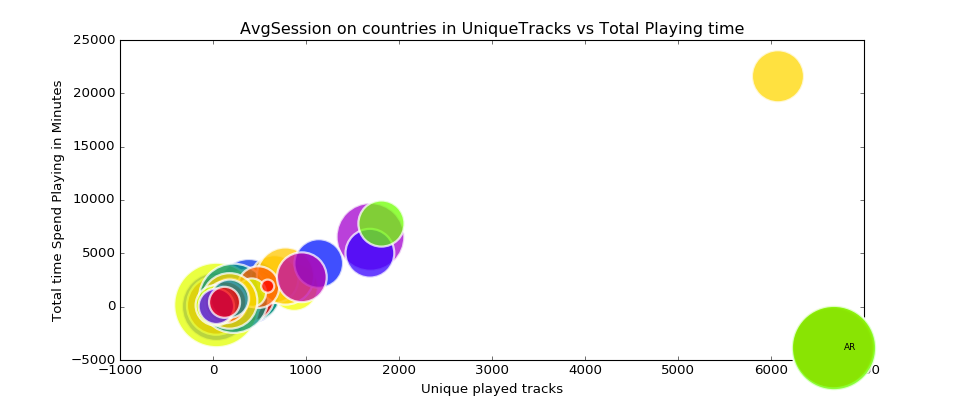

We probably need to apply some weights to make more sense on this chart, since number of US subscribers is high


In [12]:
fig2 = plt.figure(figsize=[12, 5])
cmap = plt.cm.prism
colors = cmap(np.linspace(0., 1., len(pieGender['labels'])))

# Add SubPlot for Chart 1
ax = fig.add_subplot(122)
# colors = cmap(np.linspace(0., 1., len(bubbleCountry['labels'])))
# ax.scatter(bubbleCountry['uqtracks'], 
#             bubbleCountry['totaltime'], 
#             s=bubbleCountry['avgsession'], 
#             marker='o')

                            
colors = cmap(np.linspace(0., 1., len(bubbleCountry['labels'])))
plt.scatter(bubbleCountry['uqtracks'], 
            bubbleCountry['totaltime'], 
            s=bubbleCountry['avgsession'], 
            marker='o', 
            c=colors,
           edgecolor='w',
           linewidths=2).set_alpha(0.75)
plt.xlabel('Unique played tracks')
plt.ylabel('Total time Spend Playing in Minutes')
plt.title('AvgSession on countries in UniqueTracks vs Total Playing time')
plt.legend(bubbleCountry['labels'], loc='lower right',scatterpoints=30,ncol=5,fontsize=8)
plt.show()
print ("We probably need to apply some weights to make more sense on this chart, since number of US subscribers is high")

In [13]:
# Find Overall Listen information for each active User Per Age Band that contain data matching a profile
# Total Seconds of music playing  
# Average User Session time
# Number of Unique Tracks
# Number of Total Play Activities 
dbc.execute('''SELECT  users.age_range, 
                        SUM(usage.ms_played/1000),
                        AVG((julianday(datetime(sessions.session_end,'unixepoch'))- 
                        julianday(datetime(sessions.session_start,'unixepoch')))* 86400.0),
                        COUNT(DISTINCT usage.track_id), 
                        COUNT(1)
                FROM usage
                INNER JOIN sessions ON (usage.user_id = sessions.user_id)
                INNER JOIN users ON (usage.user_id = users.user_id)                
                GROUP BY users.age_range
                ORDER BY users.age_range''')
dualyAgeRange = {
    'uqtracks' : [],
    'totaltime' : [],
    'avgsession' : [],
    'labels' : []
}
print (','.join(['Age Range','Total Seconds Played','Average Session Time','Unique Tracks','Total Activities']))
for row in dbc:
    print (','.join(str(bit) for bit in row))
    dualyAgeRange['labels'].append(str(row[0]))
    dualyAgeRange['totaltime'].append(int(row[1]/60)) #in minutes 
    dualyAgeRange['avgsession'].append(int(row[2]/60)) #in minutes    

Age Range,Total Seconds Played,Average Session Time,Unique Tracks,Total Activities
,2752,153069.0000012517,15,19
0 - 17,617363,176455.68217388322,2472,5138
18 - 24,1252258,103874.87891232339,5505,9613
25 - 29,702920,85312.97505782792,3459,5411
30 - 34,526703,101031.44161048846,2577,3374
35 - 44,610968,83685.92787051764,3510,4991
45 - 54,550009,173546.43849415192,2929,4349
55+,292880,187671.11749112103,1517,1949


<IPython.core.display.Javascript object>


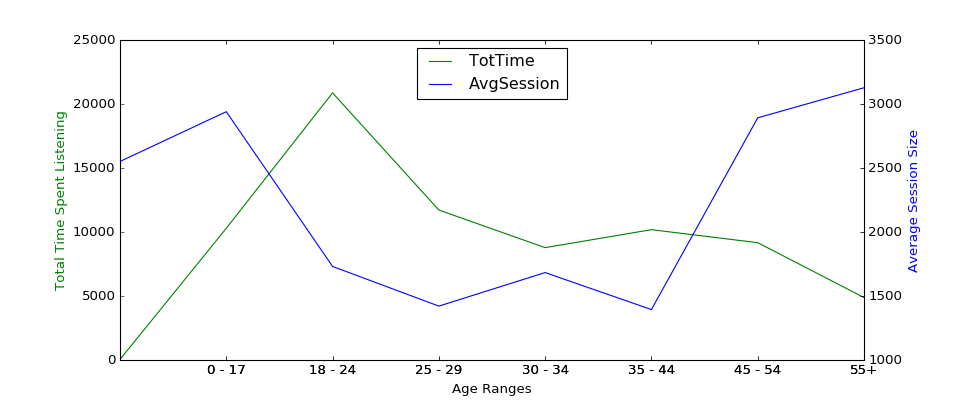

Interesting to see, How session times gets lower in 'middle' age bands but Total Time spent listening is higher on 18-24,        which means the people on this band like to listen to music 'in chunks' and not directly keep listening, according to this analisys 


In [14]:
figure3 = plt.figure(figsize=[12, 5])
colors3 = cmap(np.linspace(0., 1., len(pieGender['labels'])))

# Add SubPlot for Chart 1
axes1 = figure3.add_subplot(111)
line1 = axes1.plot(dualyAgeRange['totaltime'],'g-',label='TotTime')
plt.xticks([0,1,2,3,4,5,6,7],dualyAgeRange['labels'])
axes1.set_xlabel('Age Ranges')
axes1.set_ylabel('Total Time Spent Listening', color='g')

axes2 = figure3.add_subplot(111, sharex=axes1, frameon=False)
line2 = axes2.plot(dualyAgeRange['avgsession'],'b-',label='AvgSession')
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel('Average Session Size', color='b')


lns = line1+line2
labs = [l.get_label() for l in lns]
axes1.legend(lns, labs, loc=9)


# plt.legend((line1),('1'), loc='lower right',scatterpoints=30,ncol=5,fontsize=8)
# plt.legend((line2),('2'), loc='lower right',scatterpoints=30,ncol=5,fontsize=8)
plt.show()

print ("Interesting to see, How session times gets lower in 'middle' age bands but Total Time spent listening is higher on 18-24, \
       which means the people on this band like to listen to music 'in chunks' and not directly keep listening, according to this analisys ")

In [15]:
# Find Overall Listen information for each active User, Grouping by Date, Country, Gender, age_range
# This Grouping Set will give a rich Data Mart to be analyzed on Analytics tools like Tableau or to be preprocessed 
# with D3 to add some cool HTML charting visualizations.
# This will also output a much bigger Summary dataset than the other outputs.
# Total Seconds of music playing  
# Average User Session time
# Number of Unique Tracks
# Number of Total Play Activities 
dbc.execute('''SELECT DATE(end_timestamp,'unixepoch'), 
                        users.country,
                        users.gender,
                        users.age_range,
                        usage.product,
                        COUNT(1), 
                        COUNT(DISTINCT usage.track_id),
                        SUM(ms_played/1000/60), 
                        COUNT(DISTINCT users.user_id),
                        AVG((julianday(datetime(sessions.session_end,'unixepoch'))- 
                        julianday(datetime(sessions.session_start,'unixepoch')))* 86400.0)
                FROM usage
                INNER JOIN users ON (users.user_id = usage.user_id)
                INNER JOIN sessions ON (usage.user_id = sessions.user_id)                
                GROUP BY usage.product,users.country, users.gender,users.age_range,DATE(end_timestamp,'unixepoch')
                ORDER BY DATE(end_timestamp,'unixepoch'), users.country
                ''')
print (','.join(['Date','Country','Gender','Age Range','Product','Activities','Unique Tracks','Total ms Played',
                 'Unique Subscribers','Averate Session Time']))
for row in dbc:
    print (','.join(str(bit) for bit in row))


Date,Country,Gender,Age Range,Product,Activities,Unique Tracks,Total ms Played,Unique Subscribers,Averate Session Time
2015-10-01,AR,female,18 - 24,open,1,1,0,1,0.0
2015-10-01,AR,female,35 - 44,open,1,1,0,1,259524.0000128746
2015-10-01,AR,female,45 - 54,open,1,1,0,1,0.0
2015-10-01,AR,female,55+,open,14,13,49,1,3421.9999864697456
2015-10-01,AR,male,18 - 24,open,10,10,17,1,501047.0000177622
2015-10-01,AR,male,25 - 29,open,6,6,0,1,39.00002986192703
2015-10-01,AR,male,30 - 34,open,2,1,0,1,82360.99998056889
2015-10-01,AR,male,35 - 44,open,2,2,0,2,0.0
2015-10-01,AR,male,35 - 44,premium,39,34,88,2,8367.615377329863
2015-10-01,AT,male,18 - 24,open,70,69,12,2,117259.45711651018
2015-10-01,AT,male,45 - 54,premium,20,20,51,1,3375.0
2015-10-01,AU,female,0 - 17,open,2,2,1,1,0.0
2015-10-01,AU,male,0 - 17,open,7,7,4,1,92001.99999064207
2015-10-01,AU,female,25 - 29,premium,2,2,2,1,434142.0000091195
2015-10-01,AU,female,45 - 54,premium,33,19,87,1,171851.9999921322
2015-10-01,AU,male,35 - 44,premium,37,

This data can be used on analitycs tools, like Tableau which i di an smll Dashboard example, or apply with some D3 on a HTML page
this powerfull simple datamart makes the data easily to navigate and find new insights, dinamically filtering to find patterns.


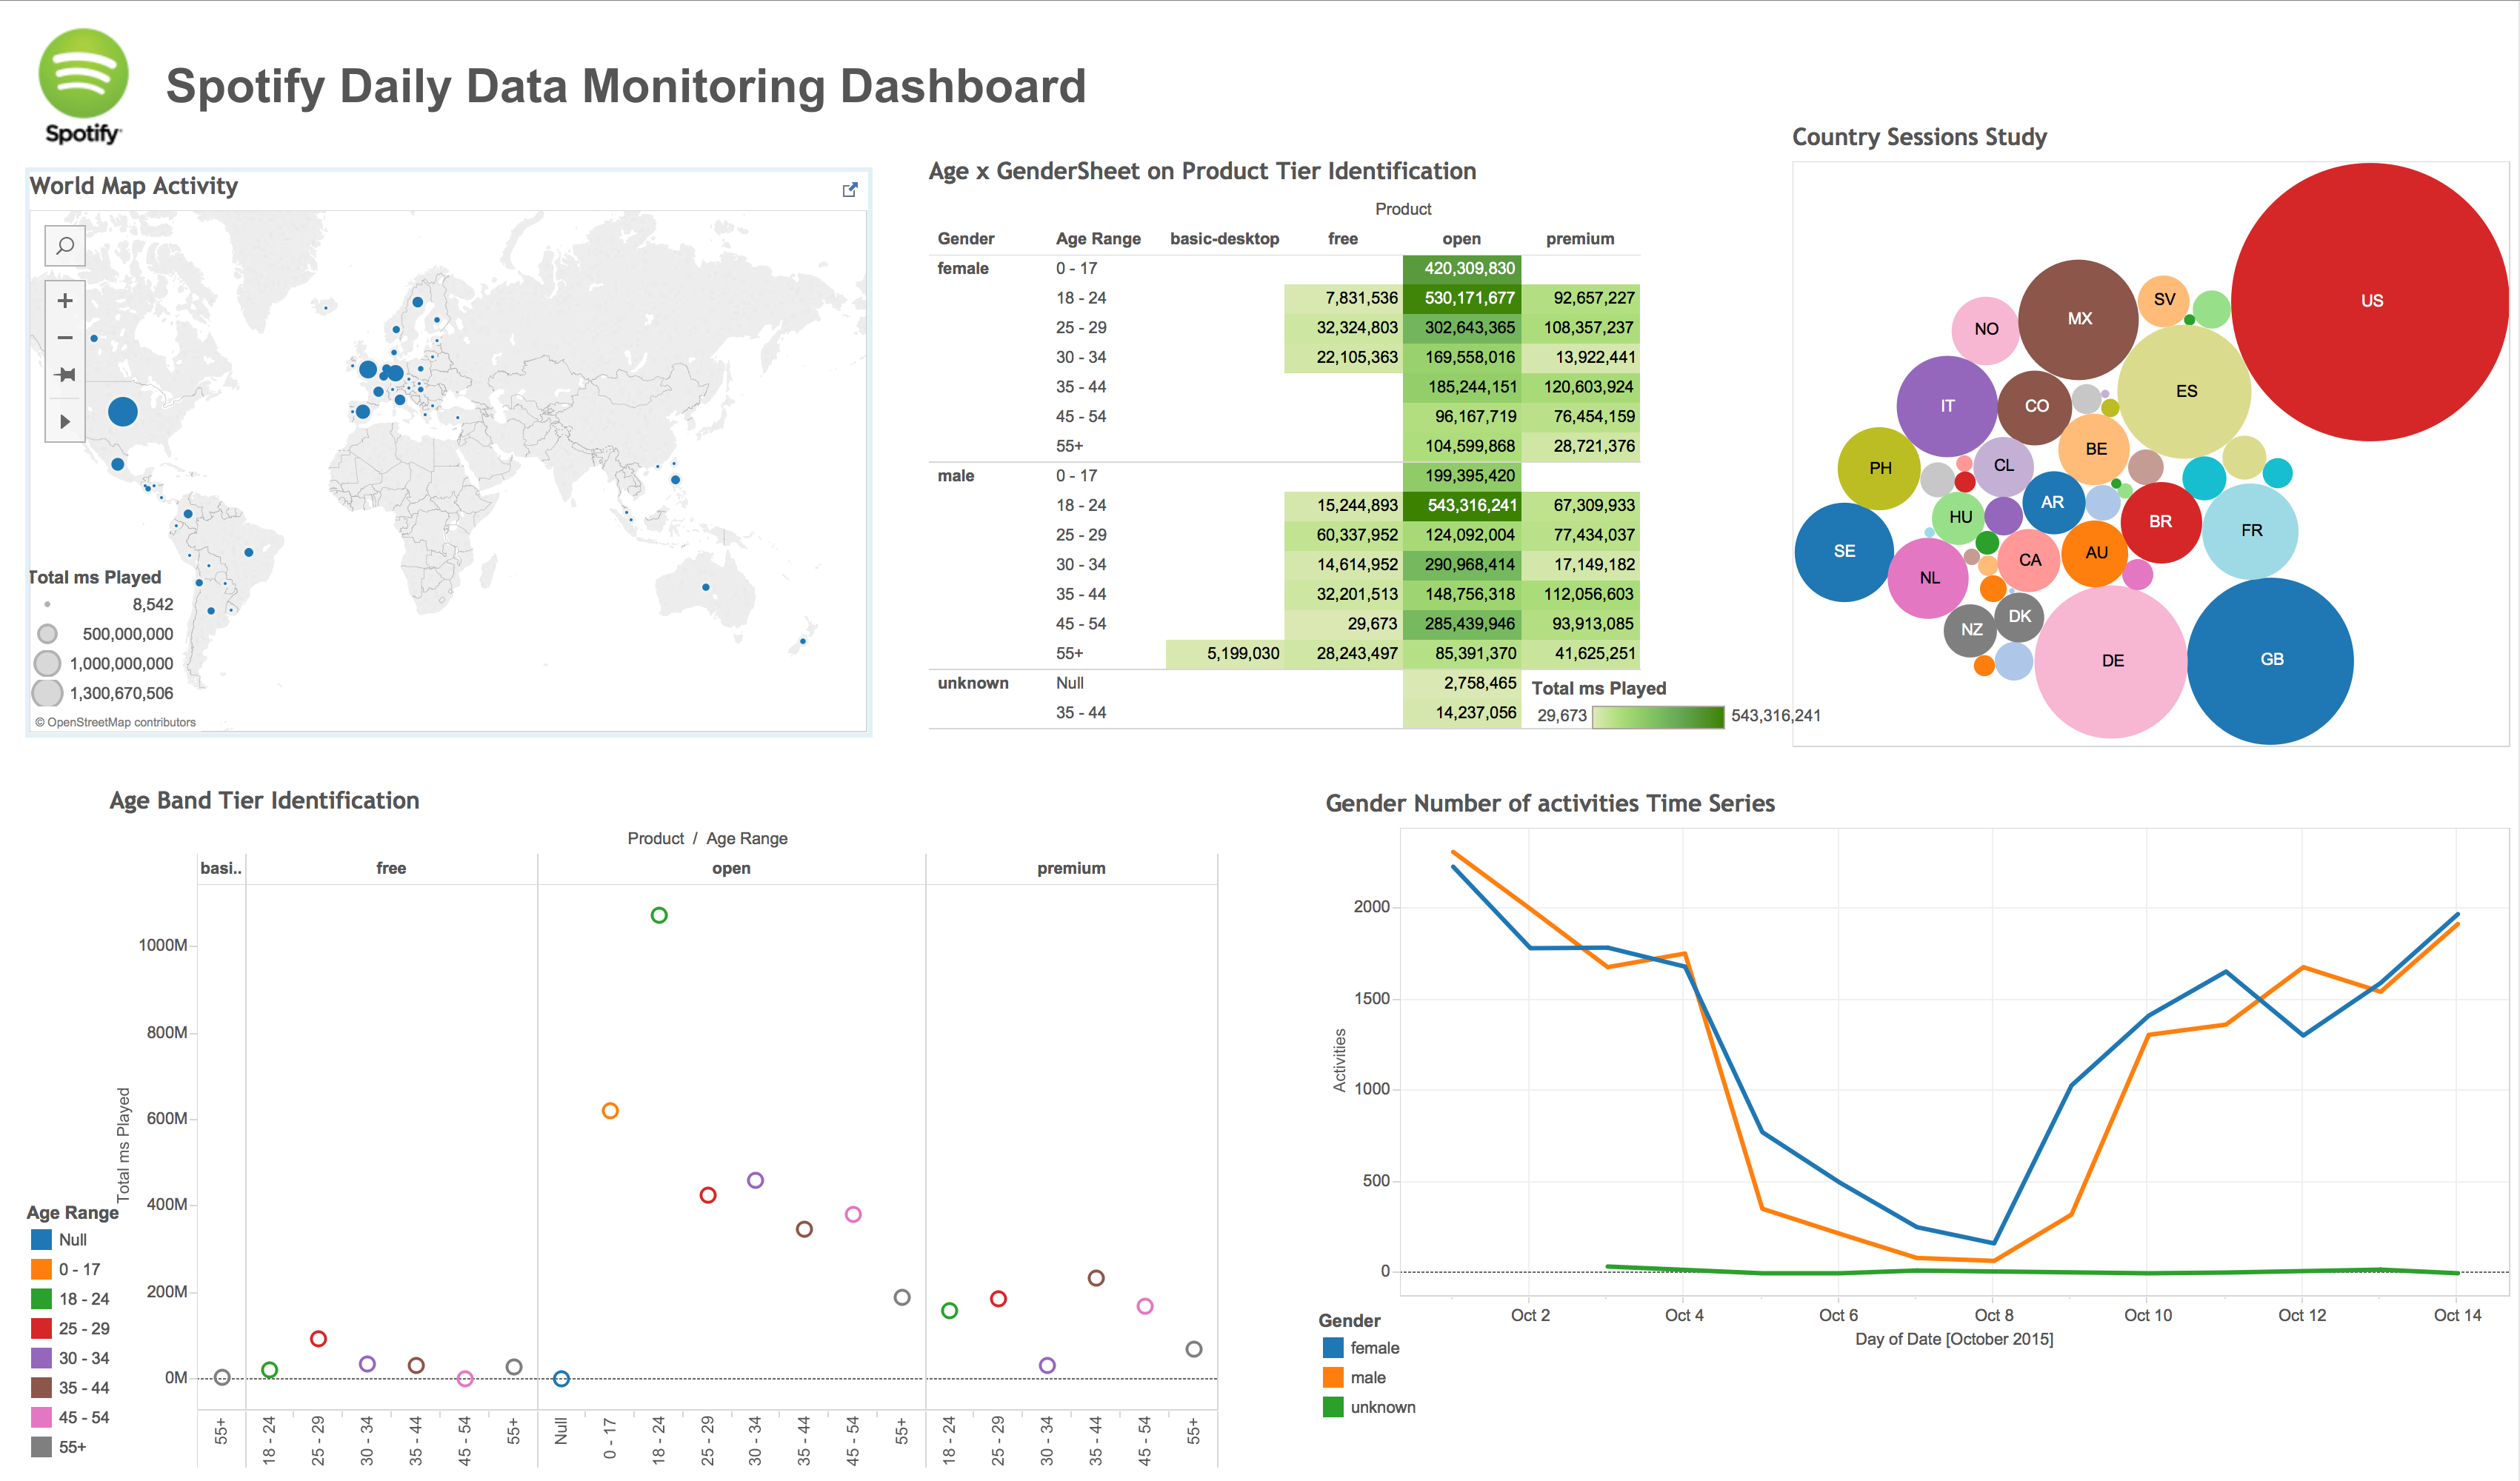

In [16]:
print("This data can be used on analitycs tools, like Tableau which i di an smll Dashboard example, or apply with some \
D3 on a HTML page")
print("this powerfull simple datamart makes the data easily to navigate and find new insights, dinamically filtering \
to find patterns.")
from IPython.display import Image
Image(filename='spotableau.png')